In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from math import gamma
import pybullet as p
import pybullet_data
import time  # Add this line to import the time module

In [11]:
# p.disconnect()

# 创建仿真环境
physicsClient = p.connect(p.GUI)  # 连接到图形界面(GUI)服务器
print("path to dataset:"+pybullet_data.getDataPath())

p.setGravity(0, 0, -9.8)  # 设置重力

path to dataset:F:\anaconda\lib\site-packages\pybullet_data


In [12]:
# 添加机器人
robotStartPos = [0, 0, 0.1]  # 机器人的起始位置
robotStartOrientation = p.getQuaternionFromEuler([0, 0, 0])  # 机器人的起始姿态
planeId = p.loadURDF("F:/anaconda/lib/site-packages/pybullet_data/plane.urdf")
robotId = p.loadURDF("F:/anaconda/lib/site-packages/pybullet_data/kuka_iiwa/model.urdf", robotStartPos, robotStartOrientation)  # 加载机器人的URDF模型文件

Evaluation Metrics:
MSE: 5.077288427934864
RMSE: 2.2532839208441673
MAE: 1.8515445708028497
R-squared: 0.6446847734561173


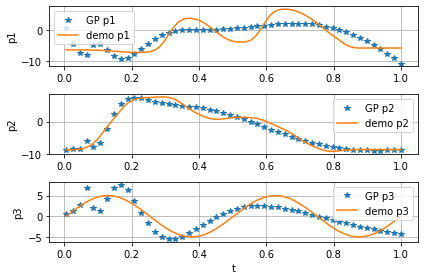

[ 0.60850425  1.27822245  2.80784102  6.81041473  2.06537869  1.21406173
  4.12082986  6.9216158   7.66585004  6.34947324  3.7936363   0.88222221
 -1.74581665 -3.74253703 -4.992105   -5.52966743 -5.47155661 -4.96559108
 -4.1600175  -3.1865746  -2.15309347 -1.14197143 -0.21191625  0.59875015
  1.26827865  1.78776756  2.15782835  2.38576555  2.48328937  2.46472398
  2.34564843  2.14189998  1.86887067  1.5410355   1.17165891  0.77263531
  0.35442792 -0.07392234 -0.50474017 -0.93162808 -1.3493602  -1.753767
 -2.14161758 -2.51050425 -2.85873247 -3.18521813 -3.48939328 -3.7711209
 -4.03061858 -4.26839101]


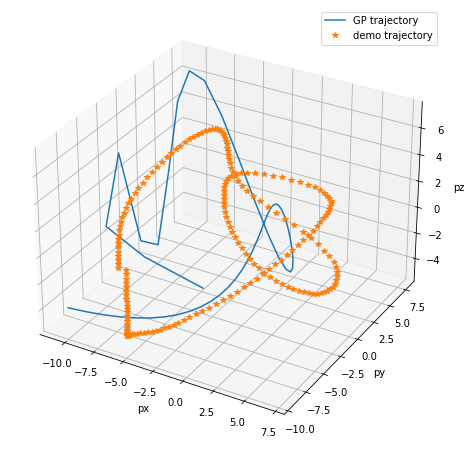

In [4]:
#| # Python Practice for GP

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from math import gamma
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


###################################################
# Load the training data
###################################################
# mat = loadmat('robInfLib-matlab/2Dletters/Y.mat')
mat = loadmat('B-new.mat')
demosNum = 10
dataset = []
for i in range(demosNum):
    data = mat['demos'][0, i]['pos'][0, 0]
    dataset.append(data)
    # plt.plot(data[0], data[1])
# plt.show()

###################################################
# Kernel function
###################################################
# def kernel(x1, x2, kh):
#     return np.dot(x1, x2)

# def kernel(x1, x2, kh, degree):
#     return (np.dot(x1, x2) + kh) ** degree

#GRB:
# def kernel(x1, x2, kh):
#     return np.exp(-kh * np.dot(x1-x2, x1-x2))

def kernel(x1, x2, kh):
    return np.tanh(kh * np.dot(x1, x2))

# def kernel(x1, x2, kh, nu):
#     diff = x1 - x2
#     dist = np.sqrt(np.dot(diff, diff))
#     term1 = (2 ** (1 - nu)) / (gamma(nu))
#     term2 = np.sqrt(2 * nu) * (kh * dist)
#     term3 = np.exp(-kh * dist)
#     return term1 * term2 * term3

# def kernel(x1, x2, alpha, sigma):
#     distance = np.linalg.norm(x1 - x2)  # 计算欧氏距离
#     return (1 + (distance ** 2) / (2 * alpha * sigma ** 2)) ** (-alpha)

# def kernel(x1, x2, kh, length_scale, periodicity):
#     diff = x1 - x2
#     dist_sq = np.dot(diff, diff)
#     term1 = 2 * np.pi * dist_sq / periodicity
#     term2 = np.sqrt(5) / length_scale
#     return np.exp(-term2 * np.sin(term1))

# def kernel(x1, x2, sigma):
#     return np.dot(x1, x2) + sigma

# def kernel(x1, x2, kh):
#     return np.exp(-kh * np.sqrt(np.dot(x1-x2, x1-x2)))
# def kernel(x, x_prime, sigma):
#     distance = np.linalg.norm(x - x_prime)  # 计算输入数据点之间的欧氏距离
#     return np.exp(-distance / (2 * sigma**2))  # 计算核函数的值


# def kernel(x1, x2, kh):
#     return np.exp(-kh * np.abs(np.dot(x1-x2, x1-x2)))

# def combined_kernel(x1, x2, kh_matern, nu, kh_grb):
#     matern_kernel_func = matern_kernel(x1, x2, kh, nu)
#     grb_kernel = kernel(x1, x2, kh_grb)
#     weight_matern = 0.71  # 权重参数，可以根据具体需求进行调整
#     weight_grb = 1-weight_matern  # 权重参数，可以根据具体需求进行调整
#     combined_kernel = weight_matern * matern_kernel_func + weight_grb * grb_kernel
#     return combined_kernel

# def combined_kernel(x1, x2, alpha, sigma, kh_grb):
#     matern_kernel_func = matern_kernel(x1, x2, kh_matern, nu)
#     grb_kernel = kernel(x1, x2, kh_grb)
#     combined_kernel = matern_kernel_func * grb_kernel
#     return combined_kernel



###################################################
# GP learning
###################################################
dt = 0.005 # time interval
dim = 3   # 2D trajectory
kh = 100# kernel parameter
lb = 0.01 # regularization parameter
pos = dataset[0] # only use the first demonstration for learning
lenth = pos.shape[1] # length of the demonstration
tau = dt * lenth # motion duraiton
degree = 8
nu = 1.5
alpha = 0.1
length_scale = 4
periodicity = 0.1
sigma = 0.01
kh_matern = 10
kh_grb = 1000

t0 = np.linspace(dt, tau, num=lenth) # time input
Kc = np.zeros((lenth, lenth)) # kernel matrix
Y = np.zeros((lenth, dim)) # trajectory output

for i in range(lenth):
    for j in range(lenth):
        Kc[i, j] = kernel(t0[i], t0[j], kh)
#         Kc[i, j] =combined_kernel(t0[i], t0[j], alpha, sigma, kh_grb)
    Y[i, :] = pos[:, i]

Kc = np.add(Kc, lb * np.eye(lenth))
weight = np.matmul(np.linalg.pinv(Kc), Y)

###################################################
# GP prediction
###################################################
t = np.linspace(dt, tau, num=int(np.round(lenth/4))) # set new time steps
# t = np.linspace(dt, 2*tau, num=int(np.round(len/4))) # prediction beyond the training region convergences to the mean
newLen = t.shape[0]
GP_pos = np.zeros((dim, newLen))
ks = np.zeros(lenth)
for i in range(newLen):
    for j in range(lenth):
        ks[j] = kernel(t[i], t0[j], kh)
#         ks[j] = combined_kernel(t[i], t0[j], alpha, sigma, kh_grb)
    GP_pos[:, i] = np.matmul(ks, weight) # ks*(Kc+lb*I)^{-1}*Y

###################################################
# Plot predicted trajectories
###################################################-
# Calculate evaluation metrics
mse = np.mean((GP_pos - pos[:, 0::4][:, :newLen]) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(GP_pos - pos[:, 0::4][:, :newLen]))
r_squared = r2_score(GP_pos.T, pos[:, 0::4][:, :newLen].T)

# Print evaluation metrics
print("Evaluation Metrics:")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print("MAE:", mae)
print(f"R-squared: {r_squared}")


fig = plt.figure()  # 设置图形的尺寸

# 绘制预测轨迹的每个维度
for d in range(dim):
    ax = fig.add_subplot(dim, 1, d+1)
    ax.plot(t, GP_pos[d, :], '*', label=f'GP p{d+1}')
    ax.plot(t0, pos[d, :], label=f'demo p{d+1}')
    ax.set_ylabel(f"p{d+1}")
    ax.legend()
    ax.grid()

# 设置最后一个子图的x轴标签
ax.set_xlabel("t")

plt.tight_layout()  # 调整子图布局以防止重叠
plt.show()

print(GP_pos[2, :])
# 绘制3D轨迹
fig = plt.figure(figsize=(8, 8))  # 设置图形的尺寸
ax = fig.add_subplot(111, projection='3d')
ax.plot(GP_pos[0, :], GP_pos[1, :], GP_pos[2, :], label='GP trajectory')
ax.plot(pos[0, :], pos[1, :], pos[2, :], '*', label='demo trajectory')
ax.set_xlabel("px")
ax.set_ylabel("py")
ax.set_zlabel("pz")
ax.legend()
# ax.set_zlim(0.1, 0.5)
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from math import gamma
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


###################################################
# Load the training data
###################################################
mat = loadmat('B_normalized.mat')
# mat = loadmat('B-.mat')
demosNum = 10
dataset = []
for i in range(demosNum):
    data = mat['demos'][0, i]['pos'][0, 0]
    dataset.append(data)
    
def kernel(x1, x2, kh):
    return np.exp(-kh * np.dot(x1-x2, x1-x2))

In [2]:
def generate_trajectory():
    dt = 0.005 # time interval
    dim = 3   # 2D trajectory
    kh = 1000  # kernel parameter
    lb = 0.001 # regularization parameter
    pos = dataset[0] # only use the first demonstration for learning
    len = pos.shape[1] # length of the demonstration
    tau = dt * len # motion duraiton
    degree = 8
    nu = 1.5
    alpha = 0.001
    length_scale = 4
    periodicity = 2
    sigma = 100000

    t0 = np.linspace(dt, tau, num=len) # time input
    Kc = np.zeros((len, len)) # kernel matrix
    Y = np.zeros((len, dim)) # trajectory output

    for i in range(len):
        for j in range(len):
            Kc[i, j] = kernel(t0[i], t0[j], kh)
        Y[i, :] = pos[:, i]

    Kc = np.add(Kc, lb * np.eye(len))
    weight = np.matmul(np.linalg.pinv(Kc), Y)

    ###################################################
    # GP prediction
    ###################################################
    t = np.linspace(dt, tau, num=int(np.round(len/4))) # set new time steps
    # t = np.linspace(dt, 2*tau, num=int(np.round(len/4))) # prediction beyond the training region convergences to the mean
    newLen = t.shape[0]
    GP_pos = np.zeros((dim, newLen))
    ks = np.zeros(len)
    for i in range(newLen):
        for j in range(len):
            ks[j] = kernel(t[i], t0[j], kh)
        GP_pos[:, i] = np.matmul(ks, weight) # ks*(Kc+lb*I)^{-1}*Y
        
    fig = plt.figure(figsize=(10, 8))

    # Plot each dimension of the predicted trajectory
    for d in range(dim):
        ax = fig.add_subplot(dim, 1, d+1)
        ax.plot(t, GP_pos[d, :], '*', label=f'GP p{d+1}')
        ax.plot(t0, pos[d, :], label=f'demo p{d+1}')
        ax.set_ylabel(f"p{d+1}")
        ax.legend()
        ax.grid()

    # Set x-axis label for the last subplot
    ax.set_xlabel("t")

    plt.show()

    # Plot 3D trajectory
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(GP_pos[0, :], GP_pos[1, :], GP_pos[2, :], label='GP trajectory')
    ax.plot(pos[0, :], pos[1, :], pos[2, :], '*', label='demo trajectory')
    ax.set_xlabel("px")
    ax.set_ylabel("py")
    ax.set_zlabel("pz")
    ax.legend()
    plt.show()
    return newLen, GP_pos


In [33]:
p.disconnect()

In [3]:
import pybullet as p
import time
import pybullet_data
import numpy as np

physicsClient = p.connect(p.GUI)  # or p.DIRECT for non-graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.81)

planeId = p.loadURDF("F:/anaconda/lib/site-packages/pybullet_data/plane.urdf")
robotId = p.loadSDF("F:/anaconda/lib/site-packages/pybullet_data/kuka_iiwa/kuka_with_gripper.sdf")

robotStartPos = [0, 0, 0]
cylinderStartPos = [1, 0, 0.3]
boxStartPos = [1, 0, 0.6 + 0.05 + 0.01]
robotStartOrientation = p.getQuaternionFromEuler([0, 0, 0])
cylinderStartOrientation = p.getQuaternionFromEuler([0, 0, 0])
boxStartOrientation = p.getQuaternionFromEuler([0, 0, 0])
pos = dataset[0]

# Load a cylinder obstacle
obstacleRadius = 0.12
obstacleHeight = 0.5
obstacleMass = 0  # Set mass to 0 for static (non-moving) obstacle
obstacleStartPos = [0.95, 0.3, 0]  # Center of the cylinder
obstacleStartOrientation = p.getQuaternionFromEuler([0, 0, 0])  # No rotation
obstacleCollisionShapeId = p.createCollisionShape(p.GEOM_CYLINDER, radius=obstacleRadius, height=obstacleHeight)
obstacleId = p.createMultiBody(obstacleMass, obstacleCollisionShapeId, -1, obstacleStartPos, obstacleStartOrientation)

p.resetBasePositionAndOrientation(robotId[0], robotStartPos, robotStartOrientation)
cylinderId = p.loadURDF("F:/anaconda/lib/site-packages/pybullet_data/cylinder.urdf", cylinderStartPos,
                       cylinderStartOrientation)
boxId = p.loadURDF("F:/anaconda/lib/site-packages/pybullet_data/cube_small.urdf", boxStartPos, boxStartOrientation)

p.getNumJoints(robotId[0])  # 得到机器人的节点总数
p.getJointInfo(robotId[0], 7)  # 得到机器人节点的信息

robot7StartPos = [0, 0, 1.2]
robotEndPos = [0.8, 0, 0.64]
# robotEndOrientation = p.getQuaternionFromEuler([1.57, 0, 1.57 + np.deg2rad(20)])
robotEndOrientation = p.getQuaternionFromEuler([1.57, 0, 1.57])
startPos_array = np.array(robot7StartPos)
endPos_array = np.array(robotEndPos)
stepNum = 5
step_array = (endPos_array - startPos_array) / stepNum

# 定义夹爪开合角度
gripper_open_angle = 0.7
gripper_closed_angle = 0.05

# 增加摩擦力
p.changeDynamics(boxId, -1, lateralFriction=100.0)
p.changeDynamics(robotId[0], -1, lateralFriction=100.0)
p.changeDynamics(cylinderId, -1, lateralFriction=100.0)
p.changeDynamics(planeId, -1, lateralFriction=100.0)
p.changeDynamics(robotId[0], 10, lateralFriction=100.0)  # 夹爪左手指
p.changeDynamics(robotId[0], 13, lateralFriction=100.0)  # 夹爪右手指


for j in range(stepNum+1):
    print(j, "step")
    robotStepPos = list(step_array + startPos_array)
    
    if j == stepNum:
        robotEndOrientation = p.getQuaternionFromEuler([1.57, 0, 1.57])
        robotStepPos = list(startPos_array)
    print(robotStepPos)    
    targetPositionsJoints = p.calculateInverseKinematics(robotId[0], 7, robotStepPos,
                                                         targetOrientation=robotEndOrientation)
    targetPositionsJoints = list(targetPositionsJoints)
    targetPositionsJoints.extend([0, 0, 0])
    targetPositionsJoints[11] = gripper_open_angle  # 设置右手指的开合角度
    targetPositionsJoints[8] = -gripper_open_angle  # 设置左手指的开合角度
    targetPositionsJoints = tuple(targetPositionsJoints)

    p.setJointMotorControlArray(robotId[0], range(14), p.POSITION_CONTROL, targetPositions=targetPositionsJoints)
    
        # 当机械臂接近目标位置时，将夹爪闭合
    if j == stepNum:
        targetPositionsJoints = list(targetPositionsJoints)
        targetPositionsJoints[11] = gripper_closed_angle
        targetPositionsJoints[13] = gripper_closed_angle
        targetPositionsJoints[8] = -gripper_closed_angle
        targetPositionsJoints[10] = -gripper_closed_angle
        targetPositionsJoints = tuple(targetPositionsJoints)
        print(targetPositionsJoints)
        p.setJointMotorControlArray(robotId[0], range(14), p.POSITION_CONTROL, targetPositions=targetPositionsJoints)
        
    for i in range(100):
        p.stepSimulation()
        time.sleep(1. / 60.)
        print("i:", i)

    print("------------------------------------------------------------------------------")
    startPos_array = np.array(robotStepPos)
    

robotEndOrientation = p.getQuaternionFromEuler([1.57, 0, 1.57])
stepNum2 = 4
endPos_array = np.array(robot7StartPos)
startPos_array = np.array(robotEndPos)
step_array = (endPos_array - startPos_array) / stepNum2
for j in range(stepNum2):
    print(j, "step")
    robotStepPos = list(step_array + startPos_array)    
    print(robotStepPos)
    targetPositionsJoints = p.calculateInverseKinematics(robotId[0], 7, robotStepPos,
                                                         targetOrientation=robotEndOrientation)

    targetPositionsJoints = list(targetPositionsJoints)
    targetPositionsJoints.extend([0, 0, 0])
    targetPositionsJoints[11] = gripper_closed_angle
    targetPositionsJoints[13] = gripper_closed_angle
    targetPositionsJoints[8] = -gripper_closed_angle
    targetPositionsJoints[10] = -gripper_closed_angle
    targetPositionsJoints = tuple(targetPositionsJoints)

    p.setJointMotorControlArray(robotId[0], range(14), p.POSITION_CONTROL, targetPositions=targetPositionsJoints)
    
        
    for i in range(100):
        p.stepSimulation()
        time.sleep(1. / 60.)
        print("i2:", i)

    print("------------------------------------------------------------------------------")
    startPos_array = np.array(robotStepPos)
    
    
    
    
robot7StartPos = [0.5, 0.5, 0.2]
robotEndPos = [0, 0, 1.2]
robotEndOrientation = p.getQuaternionFromEuler([1.57, 0, 1.57])
stepNum2 = 4
endPos_array = np.array(robot7StartPos)
startPos_array = np.array(robotEndPos)
step_array = (endPos_array - startPos_array) / stepNum2
for j in range(stepNum2):
    print(j, "step")
    robotStepPos = list(step_array + startPos_array)    
 
    targetPositionsJoints = p.calculateInverseKinematics(robotId[0], 7, robotStepPos,
                                                         targetOrientation=robotEndOrientation)

    targetPositionsJoints = list(targetPositionsJoints)
    targetPositionsJoints.extend([0, 0, 0])
    targetPositionsJoints[11] = gripper_closed_angle
    targetPositionsJoints[13] = gripper_closed_angle
    targetPositionsJoints[8] = -gripper_closed_angle
    targetPositionsJoints[10] = -gripper_closed_angle
    targetPositionsJoints = tuple(targetPositionsJoints)

    p.setJointMotorControlArray(robotId[0], range(14), p.POSITION_CONTROL, targetPositions=targetPositionsJoints)
    
        
    for i in range(100):
        p.stepSimulation()
        time.sleep(1. / 60.)
        print("i3:", i)

    print("------------------------------------------------------------------------------")
    startPos_array = np.array(robotStepPos)


# 定义三维轨迹
newLen, GP_pos = generate_trajectory()
trajectory = []  # 这里假设你有一个名为 trajectory 的三维轨迹，它是一个包含 newLen 个三维坐标的列表
stepNum3 = 1
# 用于存储末端执行器的轨迹
trajectory_points = []
# 循环遍历三维轨迹点，依次移动机械臂

# robotEndOrientation = p.getQuaternionFromEuler([-1.57, 0, 0])
    
for i in range(1, newLen):
    # 获取当前轨迹点和下一个轨迹点
    currentPos = GP_pos[:, i-1]
    nextPos = GP_pos[:, i]
    # 计算当前轨迹点和下一个轨迹点之间的步长
    step_array = (nextPos - currentPos) / stepNum3
#     print(currentPos)
    for j in range(stepNum3):
        # 计算当前步长的目标位置
        robotStepPos = list(step_array + currentPos)

        # 计算逆运动学得到末端第七个关节的目标位置
        targetPositionsJoints = p.calculateInverseKinematics(robotId[0], 7, robotStepPos, targetOrientation=robotEndOrientation)
        
        targetPositionsJoints = list(targetPositionsJoints)
        targetPositionsJoints.extend([0, 0, 0])
        targetPositionsJoints[11] = gripper_closed_angle
        targetPositionsJoints[13] = gripper_closed_angle
        targetPositionsJoints[8] = -gripper_closed_angle
        targetPositionsJoints[10] = -gripper_closed_angle
        targetPositionsJoints = tuple(targetPositionsJoints)

        # 控制机械臂运动到目标位置
        p.setJointMotorControlArray(robotId[0], range(14), p.POSITION_CONTROL, targetPositions=targetPositionsJoints)
        if i > 3:
            # 获取末端执行器（End Effector）的位置和姿态信息
            end_effector_info = p.getLinkState(robotId[0], 7)  # 这里假设末端执行器的链接索引是 7
            end_effector_pos = end_effector_info[0]

            # 将末端执行器的位置添加到轨迹点列表中
            trajectory_points.append(end_effector_pos)

        # 模拟步进
        for k in range(100):
            p.stepSimulation()
            time.sleep(1. / 240.)  # 控制仿真的步进频率

# 断开连接
p.disconnect()
# 绘制末端轨迹
trajectory_points.insert(0, pos[:,2])
trajectory_points.insert(0, pos[:,1])
trajectory_points.insert(0, pos[:,0])
trajectory_points.append(pos[:,-1])
trajectory_points = np.array(trajectory_points)

mse = mean_squared_error(pos[:, 0::4][:, :newLen], trajectory_points.T)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pos[:, 0::4][:, :newLen], trajectory_points.T)
r2 = r2_score(pos[:, 0::4][:, :newLen].T, trajectory_points)
# 打印评估结果
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory_points[:, 0], trajectory_points[:, 1], trajectory_points[:, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim(0.1, 0.5)
plt.show()


0 step
[0.16, 0.0, 1.088]
i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
i: 21
i: 22
i: 23
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
i: 31
i: 32
i: 33
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 48
i: 49
i: 50
i: 51
i: 52
i: 53
i: 54
i: 55
i: 56
i: 57
i: 58
i: 59
i: 60
i: 61
i: 62
i: 63
i: 64
i: 65
i: 66
i: 67
i: 68
i: 69
i: 70
i: 71
i: 72
i: 73
i: 74
i: 75
i: 76
i: 77
i: 78
i: 79
i: 80
i: 81
i: 82
i: 83
i: 84
i: 85
i: 86
i: 87
i: 88
i: 89
i: 90
i: 91
i: 92
i: 93
i: 94
i: 95
i: 96
i: 97
i: 98
i: 99
------------------------------------------------------------------------------
1 step
[0.32, 0.0, 0.9760000000000001]
i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14


error: Not connected to physics server.

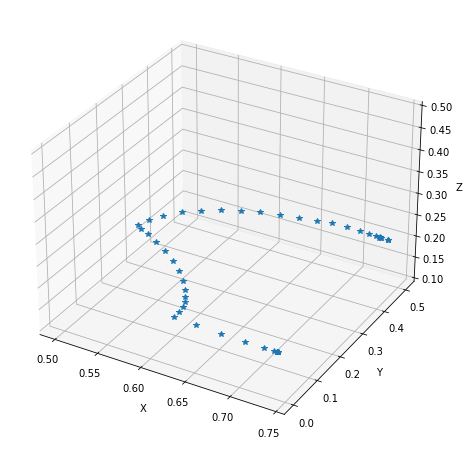

In [174]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory_points[:, 0], trajectory_points[:, 1], trajectory_points[:, 2],'*')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_zlim(0.1, 0.5)
plt.show()

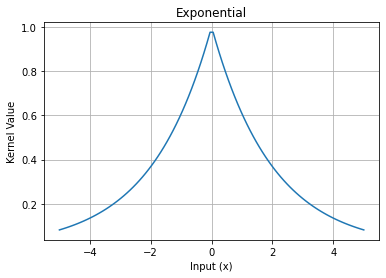

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from math import gamma
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 定义核函数，这里以高斯径向基函数（RBF）核函数为例
# def rbf_kernel(x, x_prime, sigma):
#     return np.exp(-((x - x_prime) ** 2) / (2 * sigma ** 2))

#GRB:
# def kernel(x1, x2, kh):
#     return np.exp(-kh * np.dot(x1-x2, x1-x2))

# def kernel(x1, x2, kh):
#     return np.tanh(kh * np.dot(x1, x2))

# def kernel(x1, x2, kh, nu):
#     diff = x1 - x2
#     dist = np.sqrt(np.dot(diff, diff))
#     term1 = (2 ** (1 - nu)) / (gamma(nu))
#     term2 = np.sqrt(2 * nu) * (kh * dist)
#     term3 = np.exp(-kh * dist)
#     return term1 * term2 * term3

import numpy as np
from scipy.special import gamma, kv

# def kernel(x, x_prime, sigma, length_scale, nu):
#     """
#     Matérn核函数的实现

#     参数:
#         x: 输入数据点
#         x_prime: 第二个输入数据点
#         sigma: 方差参数
#         length_scale: 长度尺度参数
#         nu: 平滑度参数

#     返回:
#         K: 核函数的值
#     """
#     r = np.linalg.norm(x - x_prime) / length_scale

#     if nu == 0.5:
#         # 绝对指数核函数（Absolute Exponential Kernel）
#         K = sigma**2 * np.exp(-r)
#     else:
#         constant = sigma**2 * (2**(nu-1) / gamma(nu))
#         factor = (np.sqrt(2*nu) * r)

#         if nu == np.inf:
#             # 高斯径向基函数核函数（Gaussian Radial Basis Function Kernel）
#             K = constant * np.exp(-factor**2)
#         else:
#             # Matérn核函数
#             K = constant * (factor**nu) * kv(nu, factor)

#     return K



# def kernel(x1, x2, alpha, sigma):
#     distance = np.linalg.norm(x1 - x2)  # 计算欧氏距离
#     return (1 + (distance ** 2) / (2 * alpha * sigma ** 2)) ** (-alpha)
# RQ
# def kernel(x, x_prime, sigma_sq, alpha, rho):
#     # Calculate the squared Euclidean distance between x and x_prime
#     distance_sq = np.sum((x - x_prime) ** 2)
    
#     # Calculate the kernel value using the Rational Quadratic formula
#     kernel_value = sigma_sq * (1 + distance_sq / (2 * alpha * rho ** 2)) ** (-alpha)
    
#     return kernel_value

# def kernel(x1, x2, kh, length_scale, periodicity):
#     diff = x1 - x2
#     dist_sq = np.dot(diff, diff)
#     term1 = 2 * np.pi * dist_sq / periodicity
#     term2 = np.sqrt(5) / length_scale
#     return np.exp(-term2 * np.sin(term1))

# def kernel(x1, x2, sigma):
#     return np.dot(x1, x2) + sigma

# def kernel(x1, x2, kh):
#     return np.exp(-kh * np.sqrt(np.dot(x1-x2, x1-x2)))
# def kernel(x, x_prime, sigma):
#     distance = np.linalg.norm(x - x_prime)  # 计算输入数据点之间的欧氏距离
#     return np.exp(-distance / (2 * sigma**2))  # 计算核函数的值

# def kernel(x1, x2, kh):
#     return np.exp(-kh * np.abs(np.dot(x1-x2, x1-x2)))
# def kernel(x, x_prime, rho):
#     distance = np.linalg.norm(x - x_prime)  # 计算输入数据点之间的欧氏距离
#     return np.exp(-distance / rho)


# 选择固定的数据点x'
x_prime = 0.0

# 在输入空间上选择一组x值
x_values = np.linspace(-5, 5, 100)

# 设置核函数的超参数
kh = 1
# 计算核函数K(x, x')的值并绘制
kernel_values = [kernel(x, x_prime, kh) for x in x_values]

# 绘制图像
plt.plot(x_values, kernel_values)
plt.xlabel('Input (x)')
plt.ylabel('Kernel Value')
plt.title('Exponential')
# Exponential
# Laplacian
plt.grid(True)
plt.show()

F:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
F:\anaconda\lib\site-packages\sklearn\gaussian_process\_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
F:\anaconda\lib\site-packages\sklearn\gaussian_process\_gpr.py:375: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


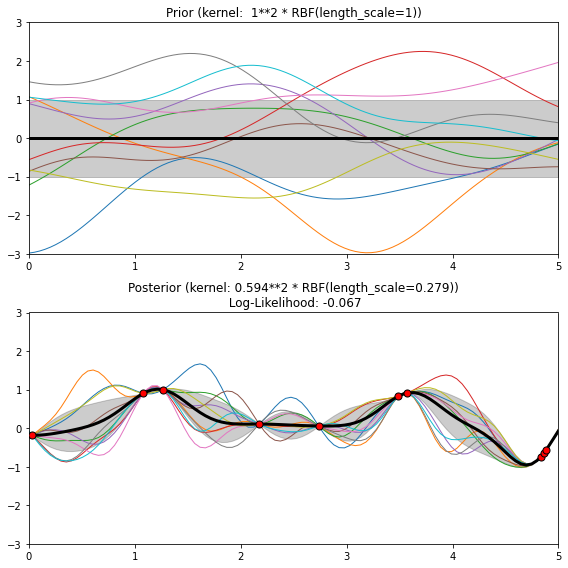

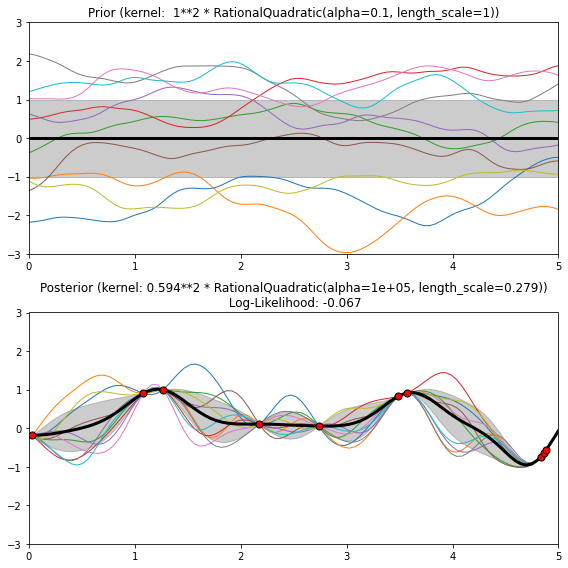

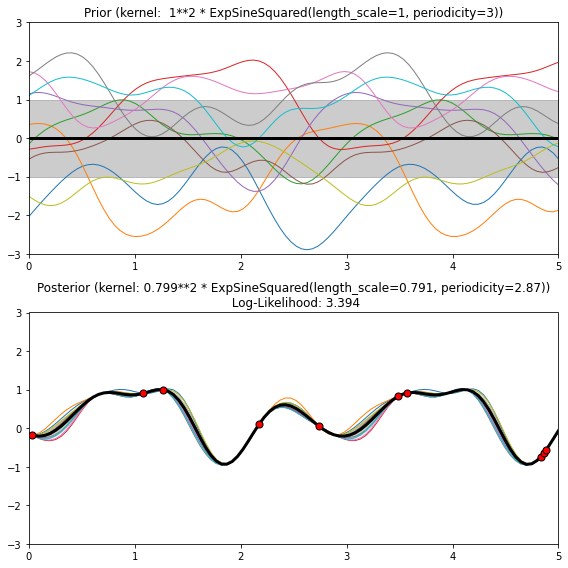

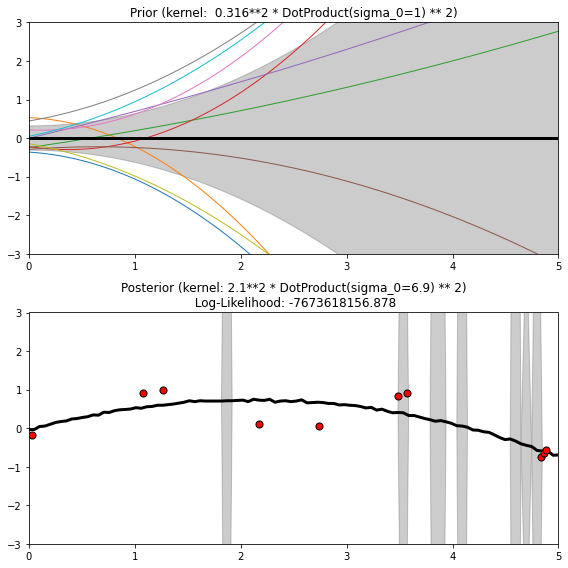

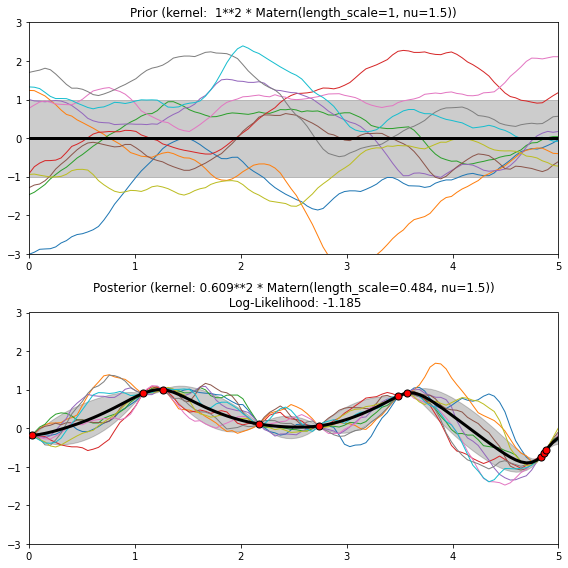

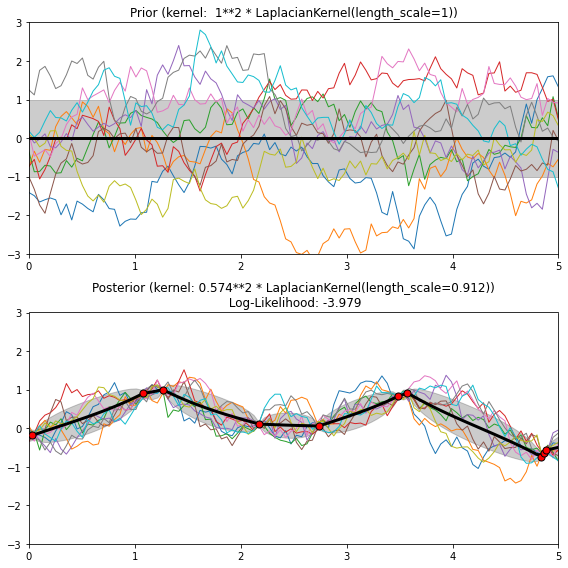

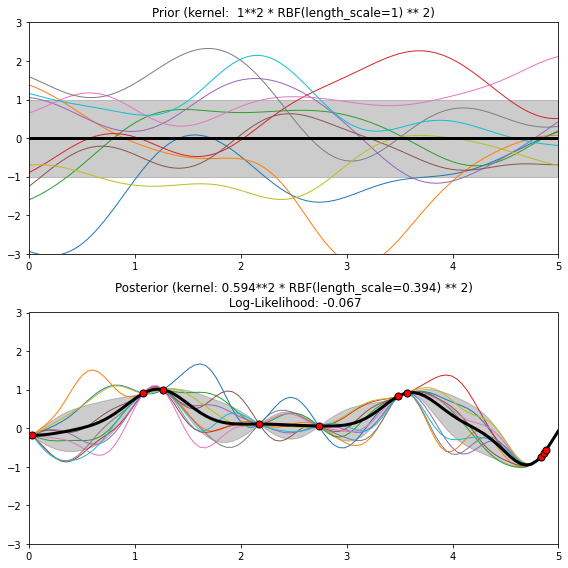

In [73]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, Exponentiation)

# 定义RBF内核作为基本内核
base_kernel = RBF()


# 现在exponentiated_kernel就是一个带有平方指数的RBF内核

kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5),
          1.0 * LaplacianKernel(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
          1.0 * Exponentiation(base_kernel, exponent=2)]

for kernel in kernels:
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show()

<ipython-input-72-112bc2e2be9a>:54: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(x_values, posterior_mean - np.sqrt(posterior_variance), posterior_mean + np.sqrt(posterior_variance),


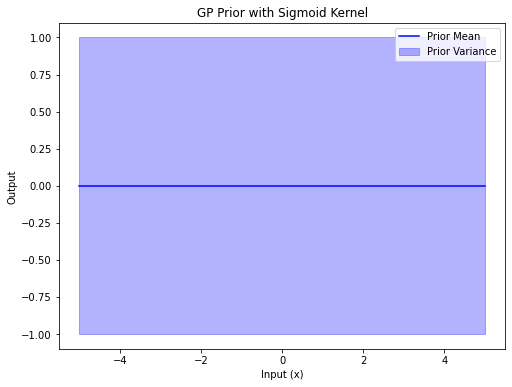

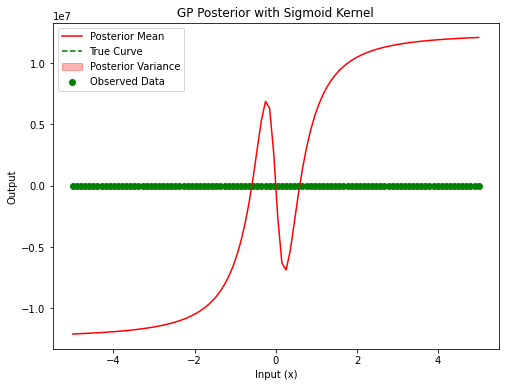

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# 定义Sigmoid核函数
def sigmoid_kernel(x, x_prime, alpha, c):
    return np.tanh(alpha * np.dot(x, x_prime) + c)

# 生成一维输入空间
x_values = np.linspace(-5, 5, 100)

# 设置Sigmoid核函数的超参数
alpha = 1.0
c = 0.0

# 计算先验和后验的均值与方差
# 这里为了简化，先验均值和方差都设置为0
# 后验均值和方差通过更新计算得到
prior_mean = np.zeros(len(x_values))
prior_variance = sigmoid_kernel(x_values, x_values, alpha, c)

# 假设我们有一条真实的曲线（真实数据分布）
true_curve = np.sin(x_values)

# 在后验中加入观测数据，假设我们观测了一些数据点
# 这里简化为在真实曲线上加入噪声模拟观测数据
# 实际应用中，观测数据是从真实数据中得到的
np.random.seed(0)
noise = np.random.normal(0, 0.1, len(x_values))
observed_data = true_curve + noise

# 使用观测数据来计算后验均值和方差
posterior_mean = np.zeros(len(x_values))
posterior_variance = np.zeros(len(x_values))
for i in range(len(x_values)):
    x = x_values[i]
    k = sigmoid_kernel(x, x_values, alpha, c)
    K = sigmoid_kernel(x_values, x_values, alpha, c)
    posterior_mean[i] = np.dot(k, np.linalg.solve(K + np.eye(len(x_values)) * 1e-6, observed_data))
    posterior_variance[i] = sigmoid_kernel(x, x, alpha, c) - np.dot(k, np.linalg.solve(K + np.eye(len(x_values)) * 1e-6, k))

# 绘制先验图像
plt.figure(figsize=(8, 6))
plt.plot(x_values, prior_mean, label='Prior Mean', color='b')
plt.fill_between(x_values, prior_mean - np.sqrt(prior_variance), prior_mean + np.sqrt(prior_variance),
                 alpha=0.3, color='b', label='Prior Variance')
plt.xlabel('Input (x)')
plt.ylabel('Output')
plt.title('GP Prior with Sigmoid Kernel')
plt.legend()

# 绘制后验图像
plt.figure(figsize=(8, 6))
plt.plot(x_values, posterior_mean, label='Posterior Mean', color='r')
plt.fill_between(x_values, posterior_mean - np.sqrt(posterior_variance), posterior_mean + np.sqrt(posterior_variance),
                 alpha=0.3, color='r', label='Posterior Variance')
plt.plot(x_values, true_curve, label='True Curve', color='g', linestyle='dashed')
plt.scatter(x_values, observed_data, label='Observed Data', color='g', marker='o')
plt.xlabel('Input (x)')
plt.ylabel('Output')
plt.title('GP Posterior with Sigmoid Kernel')
plt.legend()

plt.show()


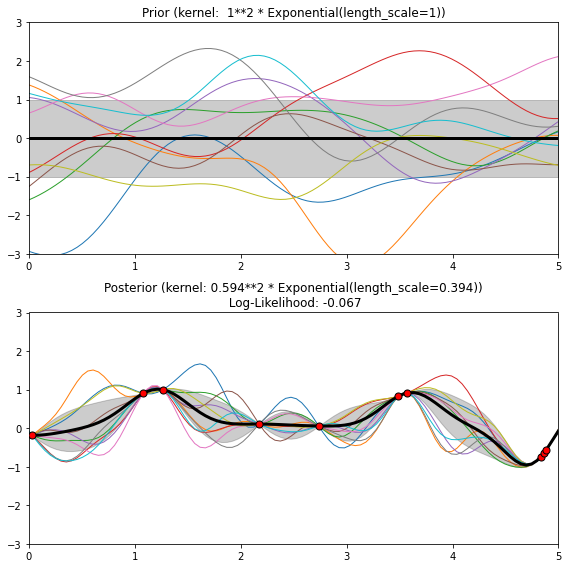

In [77]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel, Exponentiation)

# 定义RBF内核作为基本内核
base_kernel = RBF()


# 现在exponentiated_kernel就是一个带有平方指数的RBF内核

kernels = [1.0 * Exponentiation(base_kernel, exponent=2)]

for kernel in kernels:
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  1**2 * Exponential(length_scale=1))" )

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: 0.594**2 * Exponential(length_scale=0.394))\n Log-Likelihood: %.3f"
              % (gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show()

In [25]:
p.disconnect()

In [64]:
import pybullet as p
import time
import pybullet_data
import numpy as np

physicsClient = p.connect(p.GUI)  # or p.DIRECT for non-graphical version
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.81)

planeId = p.loadURDF("F:/anaconda/lib/site-packages/pybullet_data/plane.urdf")
robotId = p.loadSDF("F:/anaconda/lib/site-packages/pybullet_data/kuka_iiwa/kuka_with_gripper.sdf")

robotStartPos = [0, 0, 0]
cylinderStartPos = [1.3, 0, 0.3]
boxStartPos = [1, 0, 0.03]
robotStartOrientation = p.getQuaternionFromEuler([0, 0, 0])
cylinderStartOrientation = p.getQuaternionFromEuler([0, 0, 0])
boxStartOrientation = p.getQuaternionFromEuler([0, 0, 0])
pos = dataset[0]


p.resetBasePositionAndOrientation(robotId[0], robotStartPos, robotStartOrientation)
cylinderId = p.loadURDF("F:/anaconda/lib/site-packages/pybullet_data/cylinder.urdf", cylinderStartPos,
                       cylinderStartOrientation)
boxId = p.loadURDF("F:/anaconda/lib/site-packages/pybullet_data/cube.urdf", boxStartPos, boxStartOrientation)

p.getNumJoints(robotId[0])  # 得到机器人的节点总数
p.getJointInfo(robotId[0], 7)  # 得到机器人节点的信息

robot7StartPos = [0, 0, 0.7]
robotEndPos = [0.6, 0, 0.15]
# robotEndOrientation = p.getQuaternionFromEuler([1.57, 0, 1.57 + np.deg2rad(20)])
robotEndOrientation = p.getQuaternionFromEuler([1.57, 0, 1.57])
startPos_array = np.array(robot7StartPos)
endPos_array = np.array(robotEndPos)
stepNum = 5
step_array = (endPos_array - startPos_array) / stepNum

# 定义夹爪开合角度
gripper_open_angle = 0.7
gripper_closed_angle = 0.0

# 增加摩擦力
p.changeDynamics(boxId, -1, lateralFriction=100.0)
p.changeDynamics(robotId[0], -1, lateralFriction=100.0)
p.changeDynamics(cylinderId, -1, lateralFriction=100.0)
p.changeDynamics(planeId, -1, lateralFriction=100.0)
p.changeDynamics(robotId[0], 10, lateralFriction=100.0)  # 夹爪左手指
p.changeDynamics(robotId[0], 13, lateralFriction=100.0)  # 夹爪右手指
p.changeDynamics(robotId[0], 11, lateralFriction=100.0)  
p.changeDynamics(robotId[0], 12, lateralFriction=100.0)  

for j in range(stepNum+1):
    print(j, "step")
    robotStepPos = list(step_array + startPos_array)
    
    if j == stepNum:
        robotEndOrientation = p.getQuaternionFromEuler([1.57, 0, 1.57])
        robotStepPos = list(startPos_array)
    print(robotStepPos)    
    targetPositionsJoints = p.calculateInverseKinematics(robotId[0], 7, robotStepPos,
                                                         targetOrientation=robotEndOrientation)
#     targetPositionsJoints = list(targetPositionsJoints)
#     targetPositionsJoints.extend([0, 0, 0])
#     targetPositionsJoints[11] = gripper_open_angle  # 设置右手指的开合角度
#     targetPositionsJoints[8] = -gripper_open_angle  # 设置左手指的开合角度
#     targetPositionsJoints = tuple(targetPositionsJoints)

    p.setJointMotorControlArray(robotId[0], range(11), p.POSITION_CONTROL, targetPositions=targetPositionsJoints)
    
#         # 当机械臂接近目标位置时，将夹爪闭合
#     if j == stepNum:
#         targetPositionsJoints = list(targetPositionsJoints)
#         targetPositionsJoints[11] = gripper_closed_angle
#         targetPositionsJoints[13] = gripper_closed_angle
#         targetPositionsJoints[8] = -gripper_closed_angle
#         targetPositionsJoints[10] = -gripper_closed_angle
#         targetPositionsJoints = tuple(targetPositionsJoints)
#         print(targetPositionsJoints)
#         p.setJointMotorControlArray(robotId[0], range(14), p.POSITION_CONTROL, targetPositions=targetPositionsJoints)
        
    for i in range(100):
        p.stepSimulation()
        time.sleep(1. / 60.)
        print("i:", i)

    print("------------------------------------------------------------------------------")
    startPos_array = np.array(robotStepPos)
    
robot7StartPos = [1.2, 0, 0.15]
robotEndOrientation = p.getQuaternionFromEuler([1.57, 0, 1.57])
stepNum2 = 4
endPos_array = np.array(robot7StartPos)
startPos_array = np.array(robotEndPos)
step_array = (endPos_array - startPos_array) / stepNum2
for j in range(stepNum2):
    print(j, "step")
    robotStepPos = list(step_array + startPos_array)    
    print(robotStepPos)
    targetPositionsJoints = p.calculateInverseKinematics(robotId[0], 7, robotStepPos,
                                                         targetOrientation=robotEndOrientation)

    targetPositionsJoints = list(targetPositionsJoints)
    targetPositionsJoints.extend([0, 0, 0])
    targetPositionsJoints[11] = gripper_closed_angle
    targetPositionsJoints[13] = gripper_closed_angle
    targetPositionsJoints[8] = -gripper_closed_angle
    targetPositionsJoints[10] = -gripper_closed_angle
    targetPositionsJoints = tuple(targetPositionsJoints)

    p.setJointMotorControlArray(robotId[0], range(14), p.POSITION_CONTROL, targetPositions=targetPositionsJoints)
    
        
    for i in range(100):
        p.stepSimulation()
        time.sleep(1. / 60.)
        print("i2:", i)

    print("------------------------------------------------------------------------------")
    startPos_array = np.array(robotStepPos)
    
    
# 定义三维轨迹
newLen, GP_pos = generate_trajectory()
trajectory = []  # 这里假设你有一个名为 trajectory 的三维轨迹，它是一个包含 newLen 个三维坐标的列表
stepNum3 = 1
# 用于存储末端执行器的轨迹
trajectory_points = []
# 循环遍历三维轨迹点，依次移动机械臂

# robotEndOrientation = p.getQuaternionFromEuler([1.57, 0, 1.57+1.57])
for i in range(1, newLen):
    # 获取当前轨迹点和下一个轨迹点
    currentPos = GP_pos[:, i-1]
    nextPos = GP_pos[:, i]
    # 计算当前轨迹点和下一个轨迹点之间的步长
    step_array = (nextPos - currentPos) / stepNum3
#     print(currentPos)
    for j in range(stepNum3):
        # 计算当前步长的目标位置
        robotStepPos = list(step_array + currentPos)

        # 计算逆运动学得到末端第七个关节的目标位置
        targetPositionsJoints = p.calculateInverseKinematics(robotId[0], 7, robotStepPos, targetOrientation=robotEndOrientation)
        
        targetPositionsJoints = list(targetPositionsJoints)
        targetPositionsJoints.extend([0, 0, 0])
        targetPositionsJoints[11] = gripper_closed_angle
        targetPositionsJoints[13] = gripper_closed_angle
        targetPositionsJoints[8] = -gripper_closed_angle
        targetPositionsJoints[10] = -gripper_closed_angle
        targetPositionsJoints = tuple(targetPositionsJoints)

        # 控制机械臂运动到目标位置
        p.setJointMotorControlArray(robotId[0], range(14), p.POSITION_CONTROL, targetPositions=targetPositionsJoints)
        if i>3:
            # 获取末端执行器（End Effector）的位置和姿态信息
            end_effector_info = p.getLinkState(robotId[0], 7)  # 这里假设末端执行器的链接索引是 7
            end_effector_pos = end_effector_info[0]
#             print(end_effector_pos)
            # 将末端执行器的位置添加到轨迹点列表中
            trajectory_points.append(end_effector_pos)

        # 模拟步进
        for k in range(100):
            p.stepSimulation()
            time.sleep(1. / 960.)  # 控制仿真的步进频率

# 断开连接
p.disconnect()
# 绘制末端轨迹
trajectory_points.insert(0, pos[:,2])
trajectory_points.insert(0, pos[:,1])
trajectory_points.insert(0, pos[:,0])
trajectory_points.append(pos[:,-1])
trajectory_points = np.array(trajectory_points)

mse = mean_squared_error(pos[:, 0::4][:, :newLen], trajectory_points.T)
rmse = np.sqrt(mse)
mae = mean_absolute_error(pos[:, 0::4][:, :newLen], trajectory_points.T)
r2 = r2_score(pos[:, 0::4][:, :newLen].T, trajectory_points)
# 打印评估结果
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R-squared:", r2)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(trajectory_points[:, 0], trajectory_points[:, 1], trajectory_points[:, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


0 step
[0.12, 0.0, 0.59]
i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
i: 21
i: 22
i: 23
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
i: 31
i: 32
i: 33
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 48
i: 49
i: 50
i: 51
i: 52
i: 53
i: 54
i: 55
i: 56
i: 57
i: 58
i: 59
i: 60
i: 61
i: 62
i: 63
i: 64
i: 65
i: 66
i: 67
i: 68
i: 69
i: 70
i: 71
i: 72
i: 73
i: 74
i: 75
i: 76
i: 77
i: 78
i: 79
i: 80
i: 81
i: 82
i: 83
i: 84
i: 85
i: 86
i: 87
i: 88
i: 89
i: 90
i: 91
i: 92
i: 93
i: 94
i: 95
i: 96
i: 97
i: 98
i: 99
------------------------------------------------------------------------------
1 step
[0.24, 0.0, 0.48]
i: 0
i: 1
i: 2
i: 3
i: 4
i: 5
i: 6
i: 7
i: 8
i: 9
i: 10
i: 11
i: 12
i: 13
i: 14
i: 15
i: 16
i: 17
i: 18
i: 19
i: 20
i: 21
i: 22
i: 23
i: 24
i: 25
i: 26
i: 27
i: 28
i: 29
i: 30
i: 31
i: 32
i: 33
i: 34
i: 35
i: 36
i: 37
i: 38
i: 39
i: 40
i: 41
i: 42
i: 43
i: 44
i: 45
i: 46
i: 47
i: 

error: Not connected to physics server.